In [1]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

However, it is possible that two time series have a bidirectional relationship, meaning that time series t1 is a predictor of time series t2, and time series t2 is also a predictor for time series t1. In such a case, it would be useful to have a model that can take this bidirectional relationship into account and output predictions for bothtime series simultaneously.

This brings us to the vector autoregression (VAR) model. This particular model allows us to capture the relationship between multiple time series as they change over time. That, in turn, allows us to produce forecasts for many time series simultaneously, therefore performing multivariate forecasting.

 let’s consider a system with two time series, denoted as y1 ,t and y2 ,t, and an order of 1, meaning that p = 1. Then, using matrix notation, the VAR(1) model can be expressed as equation 10.2.



Equation 10.2

Carrying out the matrix multiplication, the mathematical expression for y1 ,t is shown in equation 10.3, and that for y2 ,t is shown in equation 10.4.

y1 ,t = C1 + ϕ1,1y1,t–1 + ϕ1,2y2,t–1 + ϵ1 ,t

Equation 10.3

y2 ,t = C2 + ϕ2,1y1,t–1 + ϕ2,2y2,t–1 + ϵ2 ,t

Equation 10.4

In equation 10.3 you’ll notice that the expression for y1 ,t includes the past value of y2 ,t. Similarly, in equation 10.4, the expression for y2 ,t includes the past value of y1 ,t. Hence, you can see how the VAR model captures the impact of each series on the other.

We can extend equation 10.3 to express a general VAR(p) model that considers p lagged values, resulting in equation 10.5. Note that the superscript does not represent an exponent but is used for indexing. For simplicity, we’ll again consider only two time series.



Equation 10.5

Just like with the AR(p) model, the VAR(p) model requires each time series to be stationary.

Vector autoregression model

The vector autoregression model VAR(p) models the relationship of two or more time series. In this model, each time series has an impact on the others. This means that past values of one time series affect the other time series, and vice versa.

The VAR(p) model can be seen as a generalization of the AR(p) model that allows for multiple time series. Just like in the AR(p) model, the order p of the VAR(p) model determines how many lagged values impact the present value of a series. In this model, however, we also include lagged values of other time series.

For two time series, the general equation for the VAR(p) model is a linear combination of a vector of constants, past values of both time series, and a vector of error terms:



Note that the time series must be stationary to apply the VAR model.

You have seen how the VAR(p) model is expressed mathematically, with their lagged values included in each expression, as shown in equations 10.3 and 10.4. This should give you a sense of how each series has an impact on the others. The VAR(p) model is only valid if both series are useful in predicting one another. Looking at the general shape of the series over time is not sufficient to support that hypothesis. Instead, we must apply the Granger causality test, which is a statistical hypothesis test to determine whether one time series is predictive of another. Only upon the success of this test can we apply the VAR model to make predictions. This is an important step in our modeling procedure when using a VAR model.

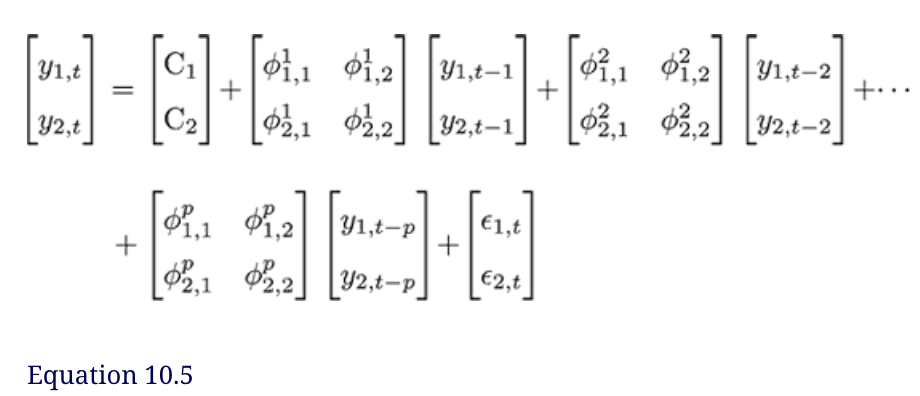

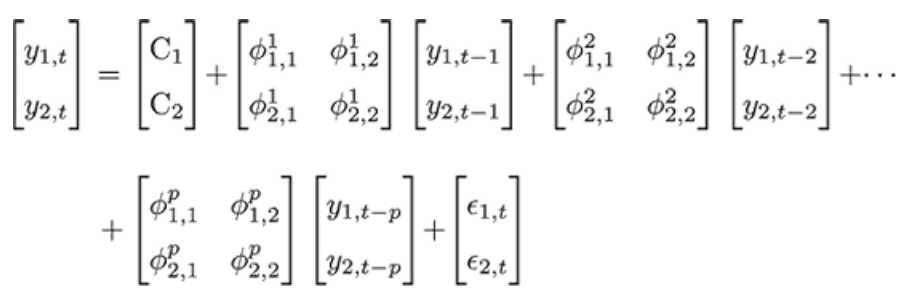

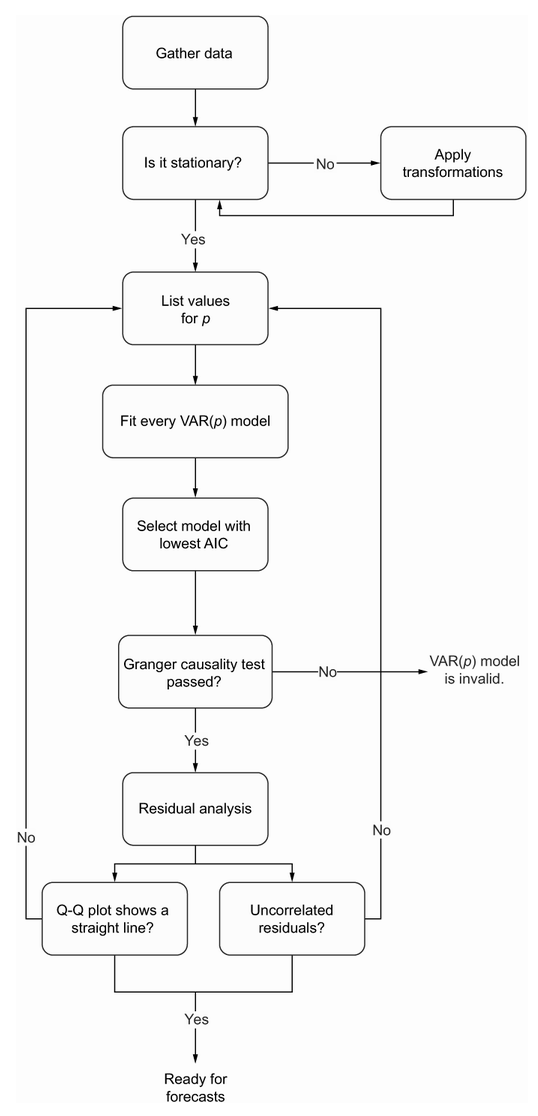

As shown in the previous section, the VAR(p) model assumes that each time series has an impact on another. Therefore, it is important to test if this relationship actually exists. Otherwise, we would be assuming a relationship that does not exist, which would introduce mistakes in the model and make our predictions invalid and unreliable.

Hence, we use the Granger causality test. This is a statistical test that helps us determine if past values of a time series y2,t can help forecast time series y1,t. If that is the case, then we say that y2,t Granger-causes y1,t.

Note that the Granger causality test is restricted to predictive causality, as we are only determining whether past values of a time series are statistically significant in predicting another time series. Furthermore, the test requires both time series to be stationary in order for the results to be valid. Also, the Granger causality test tests causality only in one direction; we must repeat the test to verify that y1 ,t also Granger-causes y2 ,t in order for the VAR model to be valid. Otherwise, we must resort to the SARIMAX model and predict each time series separately.

The null hypothesis for this test states that y2 ,t does not Granger-cause y1 ,t. Again, we will use the p-value with a critical value of 0.05 to determine whether we will reject the null hypothesis or not. In the case where the returned p-value of the Granger causality test is less than 0.05, we can reject the null hypothesis and say that y2,t Granger-causes y1,t.

You saw that the Granger causality test is performed after the VAR(p) model is selected. This is because the test requires us to specify the number of lags to include in the test, which is equivalent to the order of the model. For example, if the selected VAR(p) model is of order 3, the Granger causality test will determine if the past three values of a time series are statistically significant in forecasting the other time series.

The statsmodels library conveniently includes the Granger causality test, which we will apply in the next section when we forecast both real consumption and real disposable income.

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


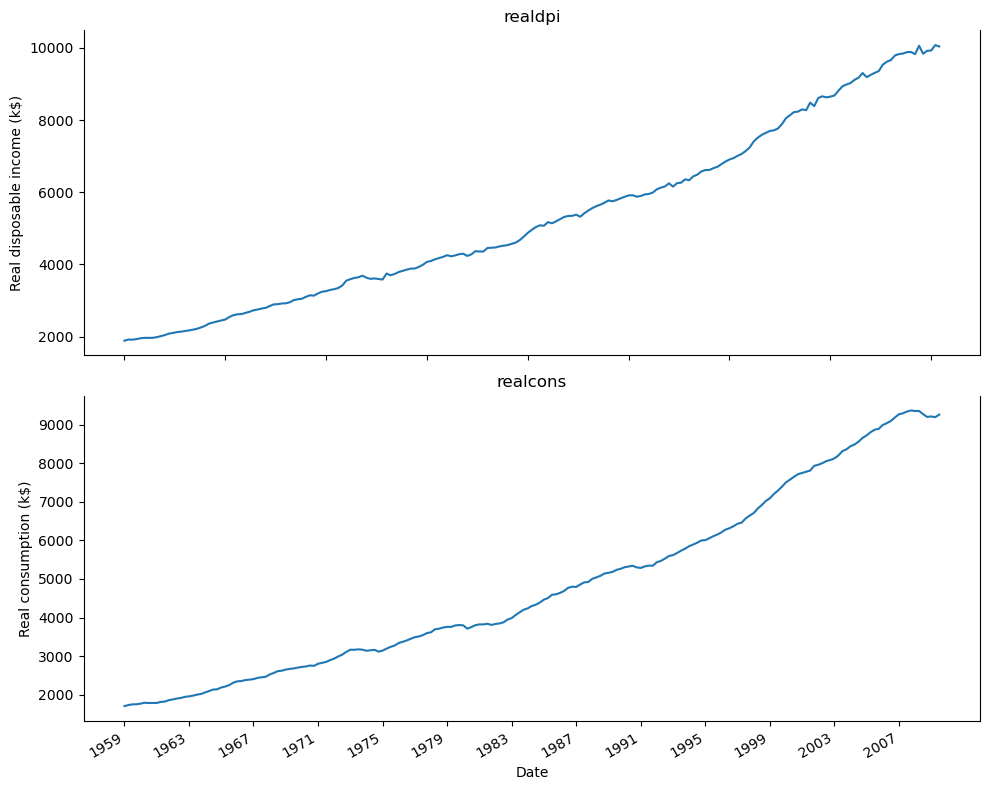

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.986025351954683
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.549912338050964
p-value: 0.9976992503412904


In [5]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673007
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


In [6]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding AIC
        
        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
    
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [7]:
# Define the targets
endog = macro_econ_data[['realdpi', 'realcons']]

# Use their diferenced version for modeling, since VARMA requires the time series to be stationary
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# Split into a trainig and test set just like in chapter 10
train = endog_diff[:162]
test = endog_diff[162:]

# Determine the range of possible values for p and q
p = range(0, 4, 1)
q = range(0, 4, 1)

# Generate a list of unique (p,q) combinations
parameters = product(p, q)
parameters_list = list(parameters)

# Run the optimization
result_df_VARMA = optimize_VARMA(train, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 0)",3123.070078
1,"(2, 1)",3124.092931
2,"(1, 3)",3125.126782
3,"(3, 2)",3125.756702
4,"(2, 3)",3125.781136
5,"(1, 2)",3126.977833
6,"(3, 1)",3129.017100
7,"(1, 1)",3129.716539
8,"(2, 2)",3129.937837
9,"(2, 0)",3130.091668


In [8]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [9]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Sat, 03 Jun 2023   BIC                           3175.559
Time:                             11:25:09   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

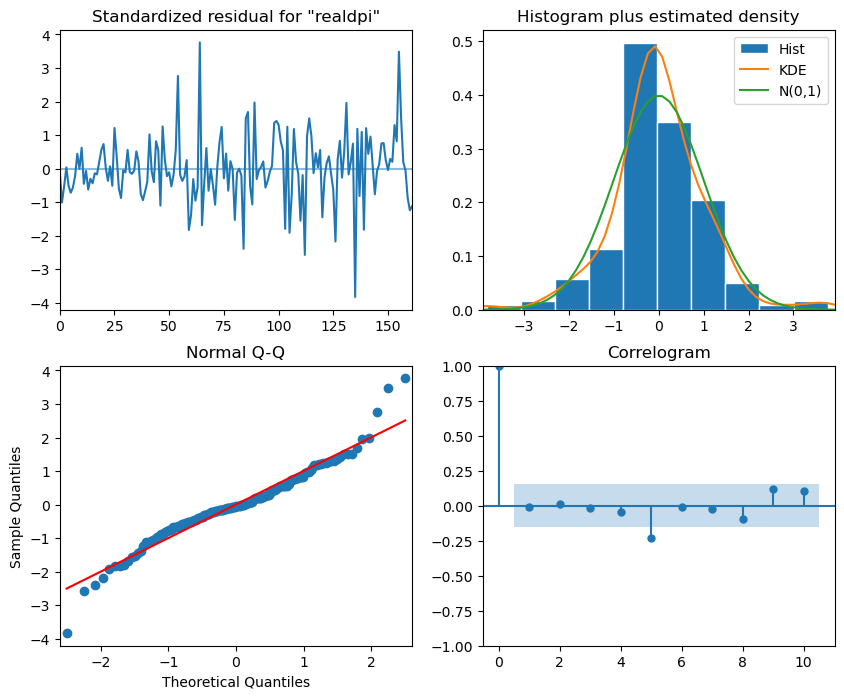

In [10]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

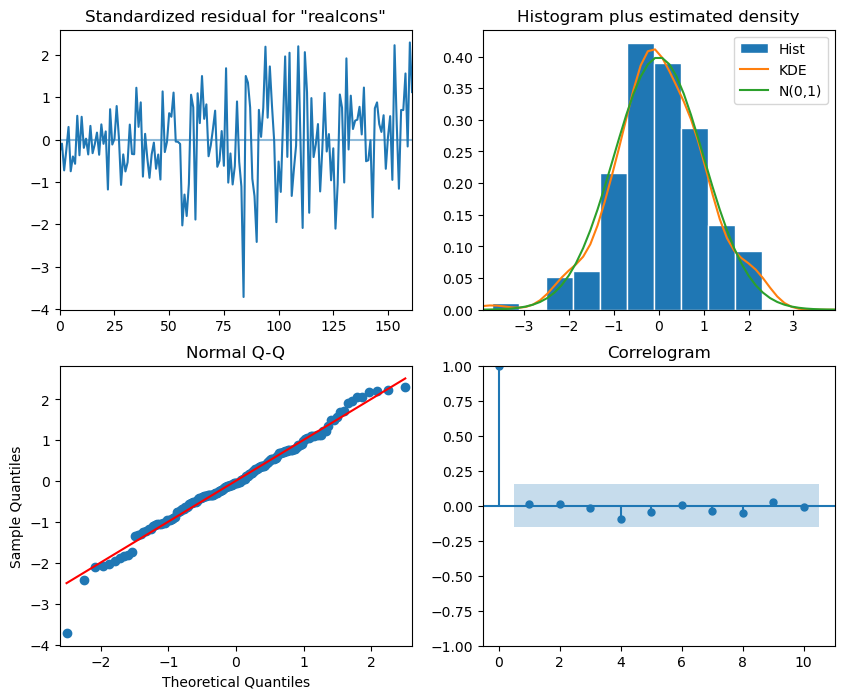

In [11]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [13]:
realgdp_residuals = best_model_fit.resid['realdpi']

val = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(val)

      lb_stat  lb_pvalue
1    0.011641   0.914079
2    0.029410   0.985403
3    0.075796   0.994575
4    0.378020   0.984237
5    9.142892   0.103499
6    9.165748   0.164469
7    9.270487   0.233815
8   10.812127   0.212573
9   13.318498   0.148716
10  15.287698   0.121920


In [15]:
realcons_residuals = best_model_fit.resid['realcons']

val = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

print(val)

     lb_stat  lb_pvalue
1   0.023757   0.877505
2   0.068698   0.966234
3   0.068777   0.995301
4   0.235628   0.993582
5   0.377556   0.995925
6   0.787230   0.992412
7   1.015086   0.994581
8   2.150240   0.976056
9   2.436944   0.982531
10  2.442617   0.991686


In [16]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VARMA':

        realdpi_pred_VARMA = []
        realcons_pred_VARMA = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMA.extend(oos_pred_realdpi)
            realcons_pred_VARMA.extend(oos_pred_realcons)
        
        return realdpi_pred_VARMA, realcons_pred_VARMA
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [17]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VARMA, realcons_pred_VARMA = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMA')

In [18]:
test = endog[163:]

test['realdpi_pred_VARMA'] = pd.Series()
test['realdpi_pred_VARMA'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMA)

test['realcons_pred_VARMA'] = pd.Series()
test['realcons_pred_VARMA'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMA)

In [19]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

In [20]:
test.head()

,realdpi,realcons,realdpi_pred_VARMA,realcons_pred_VARMA,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.224941,7354.323079,7716.0,7199.9
164,8053.4,7501.3,7897.190077,7430.252000,7716.0,7199.9
165,8135.9,7571.8,7960.564871,7496.624306,7716.0,7199.9
166,8222.3,7645.9,8014.757071,7556.606726,7716.0,7199.9
167,8234.6,7713.5,8080.701763,7630.989437,8135.9,7571.8


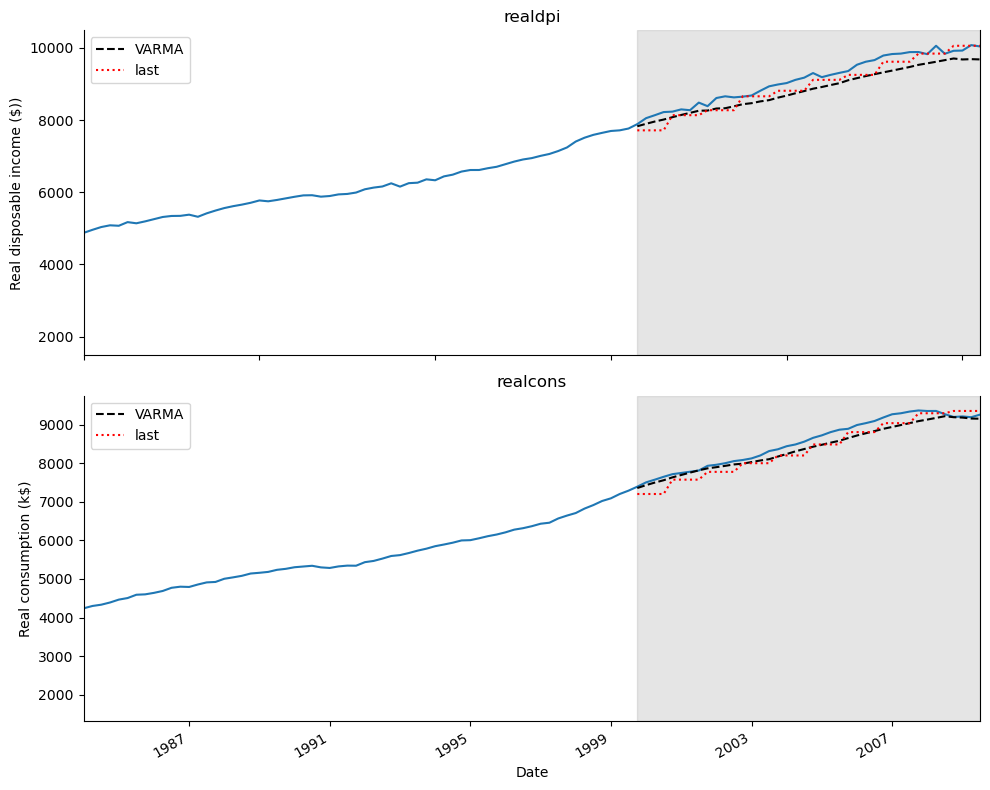

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VARMA'], 'k--', label='VARMA')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VARMA'], 'k--', label='VARMA')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()


In [22]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_realdpi_VARMA = mape(test['realdpi'], test['realdpi_pred_VARMA'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMA = mape(test['realcons'], test['realcons_pred_VARMA'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])


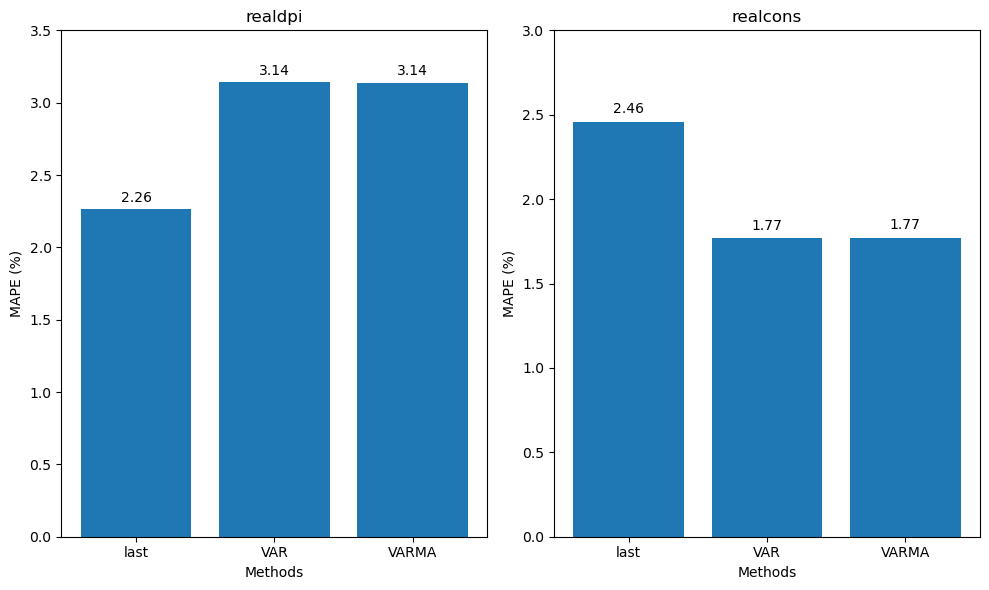

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR', 'VARMA']
y1 = [mape_realdpi_last, 3.14, mape_realdpi_VARMA]    # From chapter 10, VAR model achieved a MAPE of 3.14%
y2 = [mape_realcons_last, 1.77, mape_realcons_VARMA]  # From chapter 10, VAR model achieved a MAPE of 1.77%

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

# Use a VARMAX model to predict realdpi and realcons

In [24]:
def optimize_VARMAX(endog, exog, parameters_list):
    """
        Returns a dataframe with (p,q) and AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue
    
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [25]:
# Define the targets
endog = macro_econ_data[['realdpi', 'realcons']]

# Use their diferenced version for modeling, since VARMA requires the time series to be stationary
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# Select the exogenous variables. Note that they do not be to be stationary to be used
exog_cols = macro_econ_data.columns.drop(['year', 'quarter', 'realdpi', 'realcons'])
# Make sure that the index of exog is aligned with train
exog = macro_econ_data[exog_cols][1:163]

# Split into a trainig and test set just like in chapter 10
train = endog_diff[:162]
test = endog_diff[162:]

# Determine the range of possible values for p and q
p = range(0, 4, 1)
q = range(0, 4, 1)

# Generate a list of unique (p,q) combinations
parameters = product(p, q)
parameters_list = list(parameters)

# Run the optimization
result_df_VARMAX = optimize_VARMAX(train, exog, parameters_list)
result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 0)",3113.465986
1,"(0, 1)",3117.326734
2,"(2, 0)",3118.688860
3,"(1, 1)",3119.158963
4,"(3, 0)",3121.521262
5,"(0, 3)",3122.398466
6,"(0, 2)",3122.758519
7,"(1, 2)",3125.051544
8,"(2, 1)",3125.652019
9,"(1, 3)",3126.778315


In [26]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [1])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [1])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=35.3881 , p=0.0000  , df=1
likelihood ratio test: chi2=32.5962 , p=0.0000  , df=1
parameter F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=7.8540  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7045  , p=0.0055  , df=1
parameter F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1


In [27]:
best_model = VARMAX(train, exog, order=(1,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                             VARX(1)   Log Likelihood               -1527.733
                               + intercept   AIC                           3113.466
Date:                     Sat, 03 Jun 2023   BIC                           3203.006
Time:                             11:31:16   HQIC                          3149.821
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.08, 0.29   Jarque-Bera (JB):         40.79, 18.63
Prob(Q):                        0.78, 0.59   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         5.80, 2.63   Skew:                      0.12

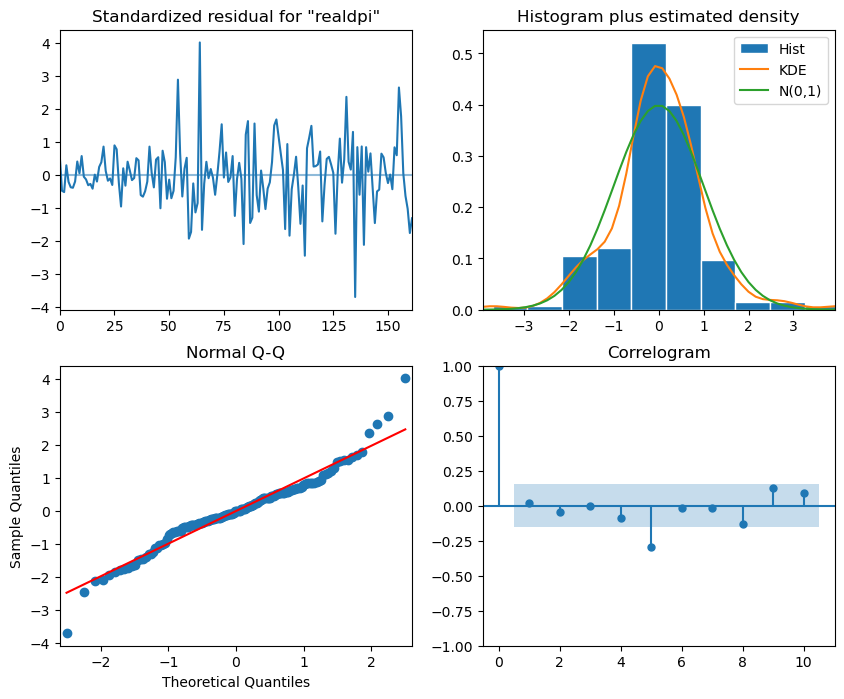

In [28]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

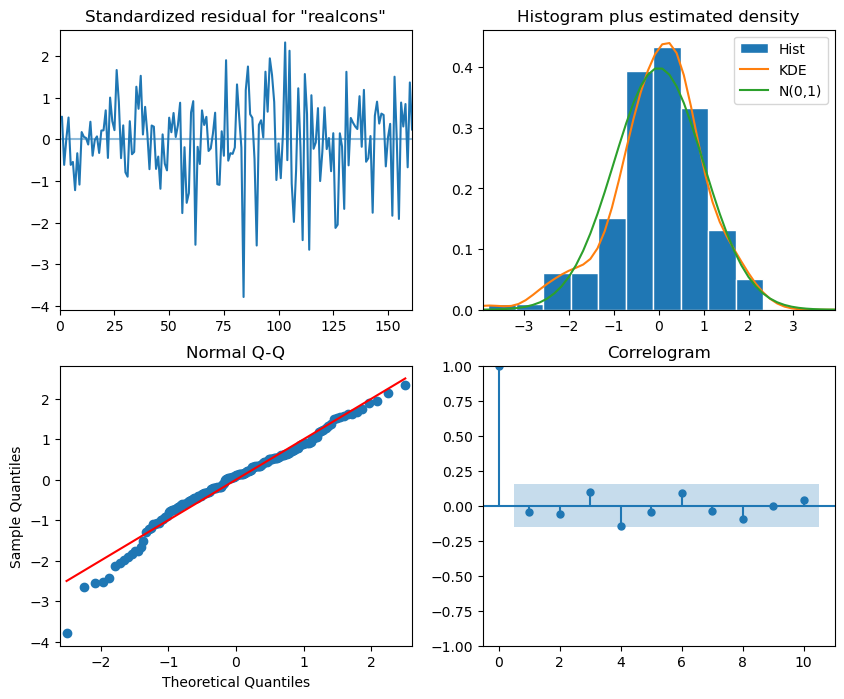

In [29]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [31]:
realgdp_residuals = best_model_fit.resid['realdpi']

val = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(val)

      lb_stat  lb_pvalue
1    0.075524   0.783458
2    0.411993   0.813836
3    0.412622   0.937623
4    1.792401   0.773872
5   16.220383   0.006242
6   16.286550   0.012296
7   16.327306   0.022289
8   19.273314   0.013464
9   21.990612   0.008909
10  23.487438   0.009084


Here, we see that the p-value is less than 0.05 starting at lag 5. This is worrying becasue it seems that the residuals of realdpi are correlated starting at lag 5. For the sake of completing the exercise, let's keep going, especially becasue the visual inspection of the residuals all point to the conclusion that the residuals behave like white noise.

You can see that sometimes, there is a bit of judgement to be made when we are in a grey zone.

In [32]:
realgdp_residuals = best_model_fit.resid['realcons']

val = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(val)

      lb_stat  lb_pvalue
1    0.267015   0.605341
2    2.020628   0.364105
3    6.832538   0.077431
4    9.591459   0.047902
5   11.193142   0.047682
6   13.395337   0.037170
7   13.696266   0.056855
8   17.971023   0.021445
9   17.971437   0.035506
10  18.222728   0.051321


In [33]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VARMAX':

        realdpi_pred_VARMAX = []
        realcons_pred_VARMAX = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], exog[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1, exog=exog.iloc[-1])    # Use the exogenous variable to 
                                                                                       # generate predictions
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMAX.extend(oos_pred_realdpi)
            realcons_pred_VARMAX.extend(oos_pred_realcons)
        
        return realdpi_pred_VARMAX, realcons_pred_VARMAX
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [34]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1    # We can only predict the next timestep, since we have exogenous variables (just like the SARIMAX model)

exog = macro_econ_data[exog_cols][1:]

realdpi_pred_VARMAX, realcons_pred_VARMAX = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')

In [35]:
test = endog[163:]

test['realdpi_pred_VARMAX'] = pd.Series()
test['realdpi_pred_VARMAX'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMAX)

test['realcons_pred_VARMAX'] = pd.Series()
test['realcons_pred_VARMAX'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMAX)

In [36]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

In [37]:
test.head()

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7953.527744,7272.921643,7716.0,7199.9
164,8053.4,7501.3,8092.954307,7291.193376,7765.9,7286.4
165,8135.9,7571.8,8110.459754,7299.067313,7887.7,7389.2
166,8222.3,7645.9,8143.497357,7354.200169,8053.4,7501.3
167,8234.6,7713.5,8196.331003,7444.212117,8135.9,7571.8


In [38]:
mape_realdpi_VARMAX = mape(test['realdpi'], test['realdpi_pred_VARMAX'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMAX = mape(test['realcons'], test['realcons_pred_VARMAX'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

In [39]:
print(mape_realdpi_VARMAX)

25.667291180444828


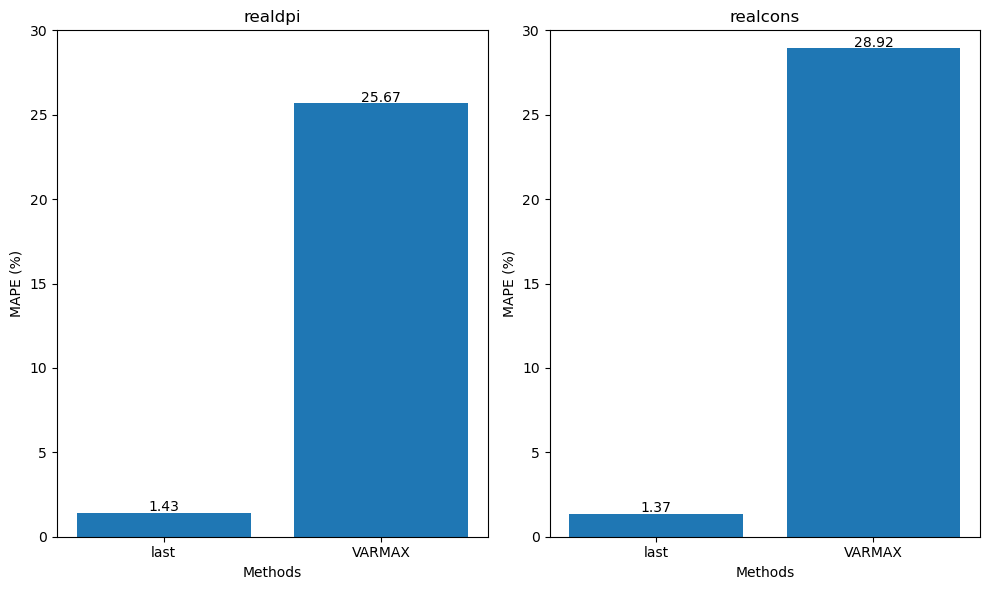

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VARMAX']
y1 = [mape_realdpi_last, mape_realdpi_VARMAX]   
y2 = [mape_realcons_last, mape_realcons_VARMAX] 

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 30)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 30)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

plt.tight_layout()

Clearly, using a VARMAX model is a very bad idea in this situation, since it achieves a very high MAPE compared to a simple baseline. Note that we cannot compare this performance to the VAR and VARMA models, since the forecast window is different for VARMAX.